In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers accelerate opencv-python matplotlib


Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
!pip install torch torchvision torchaudio


In [ ]:
pip install transformers accelerate opencv-python torch torchvision matplotlib


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import cv2
import torch
import numpy as np
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from PIL import Image

# Load the Depth Anything v2 model
model_id = "LiheYoung/depth-anything-large-hf"
processor = AutoImageProcessor.from_pretrained(model_id)
model = AutoModelForDepthEstimation.from_pretrained(model_id)
model.eval()

# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize webcam
cap = cv2.VideoCapture(0)  # 0 for default webcam

if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

print("Press 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame.")
        break

    # Convert BGR (OpenCV) to RGB (PIL)
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(img_rgb)

    # Preprocess and infer
    inputs = processor(images=pil_image, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        depth = outputs.predicted_depth.squeeze().cpu().numpy()

    # Normalize depth for visualization
    depth_min = depth.min()
    depth_max = depth.max()
    depth_vis = (depth - depth_min) / (depth_max - depth_min)
    depth_vis = (depth_vis * 255).astype(np.uint8)

    # Resize depth map to match frame size
    depth_vis = cv2.resize(depth_vis, (frame.shape[1], frame.shape[0]))

    # Apply colormap for better visualization
    depth_colored = cv2.applyColorMap(depth_vis, cv2.COLORMAP_INFERNO)

    # Combine original and depth view side-by-side
    combined = np.hstack((frame, depth_colored))

    # Show
    cv2.imshow('Webcam | Depth Anything v2', combined)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Press 'q' to quit.


In [ ]:
import cv2
import torch
import numpy as np
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from PIL import Image

# Load model
model_id = "LiheYoung/depth-anything-large-hf"
processor = AutoImageProcessor.from_pretrained(model_id)
model = AutoModelForDepthEstimation.from_pretrained(model_id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# Set known reference: distance to object in meters at center of frame
KNOWN_DISTANCE_METERS = 1.5  # 🔁 change this based on a known reference
REFERENCE_PIXEL_DEPTH = None

# Start webcam
cap = cv2.VideoCapture(0)
cap.set(3, 320)
cap.set(4, 240)

print("Press 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(rgb).resize((384, 384))
    inputs = processor(images=pil_image, return_tensors="pt").to(device)

    with torch.no_grad():
        depth = model(**inputs).predicted_depth.squeeze().cpu().numpy()

    # Normalize for display
    depth_min, depth_max = depth.min(), depth.max()
    depth_norm = (depth - depth_min) / (depth_max - depth_min + 1e-6)
    depth_display = cv2.resize((depth_norm * 255).astype(np.uint8), (frame.shape[1], frame.shape[0]))
    depth_color = cv2.applyColorMap(depth_display, cv2.COLORMAP_INFERNO)

    # Resize depth for metric calculation
    raw_depth_resized = cv2.resize(depth, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_LINEAR)

    # Get depth at center
    center_x, center_y = frame.shape[1] // 2, frame.shape[0] // 2
    center_depth_value = raw_depth_resized[center_y, center_x]

    # Step 1: Capture reference once (first frame)
    if REFERENCE_PIXEL_DEPTH is None and center_depth_value > 0:
        REFERENCE_PIXEL_DEPTH = center_depth_value
        SCALE_FACTOR = KNOWN_DISTANCE_METERS / REFERENCE_PIXEL_DEPTH
        print(f"[Calibration] Scale factor set: {SCALE_FACTOR:.4f} m/relative_unit")

    # Step 2: Convert to meters
    if REFERENCE_PIXEL_DEPTH:
        center_depth_meters = center_depth_value * SCALE_FACTOR
        text = f"Depth @ center: {center_depth_meters:.2f} m"
    else:
        text = "Calibrating..."

    # Show circle and text
    cv2.circle(depth_color, (center_x, center_y), 5, (0, 255, 0), -1)
    cv2.putText(depth_color, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

    # Stack and show
    combined = np.hstack((frame, depth_color))
    cv2.imshow("Webcam | Depth Anything v2 + Meters", combined)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Press 'q' to quit.


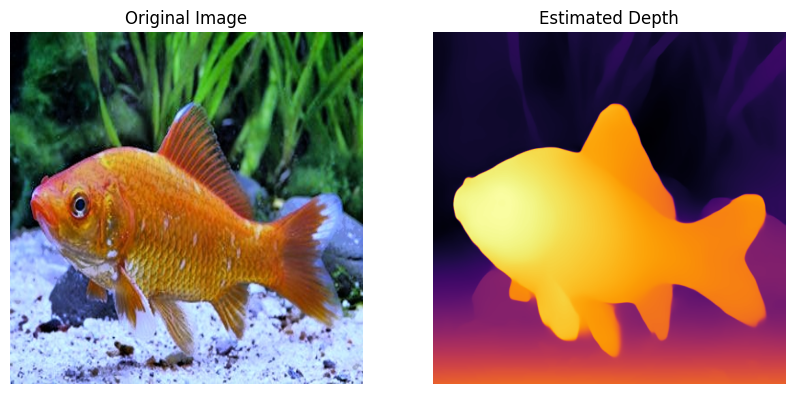

In [ ]:
import torch
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Load model
model_id = "LiheYoung/depth-anything-large-hf"
processor = AutoImageProcessor.from_pretrained(model_id)
model = AutoModelForDepthEstimation.from_pretrained(model_id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# Load sample image (upload or use test image)
img_path = "/content/final_enhanced_image.jpg"  # upload an image to Colab first
image = Image.open(img_path).convert("RGB").resize((384, 384))

# Process
inputs = processor(images=image, return_tensors="pt").to(device)
with torch.no_grad():
    depth = model(**inputs).predicted_depth.squeeze().cpu().numpy()

# Normalize and display
depth_norm = (depth - depth.min()) / (depth.max() - depth.min() + 1e-6)
depth_colored = cv2.applyColorMap((depth_norm * 255).astype(np.uint8), cv2.COLORMAP_INFERNO)
depth_colored = cv2.cvtColor(depth_colored, cv2.COLOR_BGR2RGB)

# Show using matplotlib
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Estimated Depth")
plt.imshow(depth_colored)
plt.axis("off")
plt.show()


🔎 Raw depth at center pixel: 186.4009 (relative units)
📏 Estimated depth at center: 1.50 meters


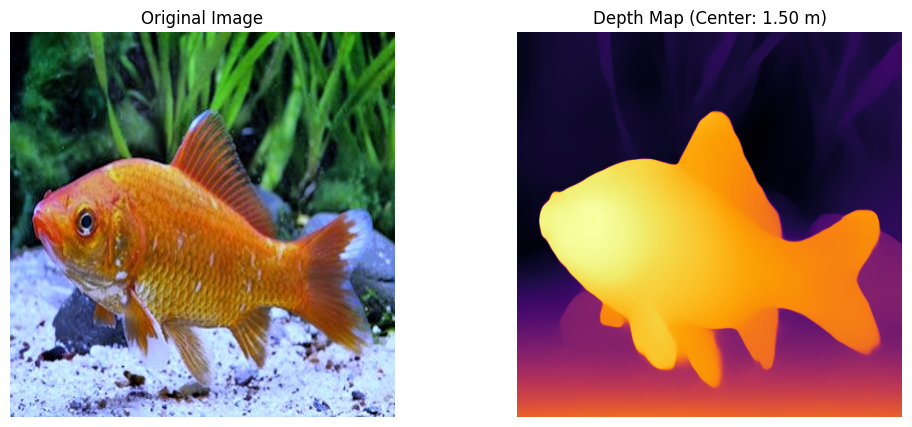

In [ ]:
import torch
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Load model
model_id = "LiheYoung/depth-anything-large-hf"
processor = AutoImageProcessor.from_pretrained(model_id)
model = AutoModelForDepthEstimation.from_pretrained(model_id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# Load image (upload image to /content or use your path)
img_path = "/content/final_enhanced_image.jpg"  # Replace with your uploaded image path
image = Image.open(img_path).convert("RGB").resize((384, 384))

# Process
inputs = processor(images=image, return_tensors="pt").to(device)
with torch.no_grad():
    depth = model(**inputs).predicted_depth.squeeze().cpu().numpy()

# Normalize for display
depth_norm = (depth - depth.min()) / (depth.max() - depth.min() + 1e-6)
depth_colored = cv2.applyColorMap((depth_norm * 255).astype(np.uint8), cv2.COLORMAP_INFERNO)
depth_colored = cv2.cvtColor(depth_colored, cv2.COLOR_BGR2RGB)

# Calculate center depth value
center_x, center_y = depth.shape[1] // 2, depth.shape[0] // 2
center_depth_value = depth[center_y, center_x]
print(f"🔎 Raw depth at center pixel: {center_depth_value:.4f} (relative units)")

# Optional: Convert to meters using a known reference
KNOWN_DISTANCE_METERS = 1.5
REFERENCE_PIXEL_DEPTH = center_depth_value  # assuming we calibrated at this distance
SCALE_FACTOR = KNOWN_DISTANCE_METERS / REFERENCE_PIXEL_DEPTH
depth_meters = center_depth_value * SCALE_FACTOR
print(f"📏 Estimated depth at center: {depth_meters:.2f} meters")

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Depth Map (Center: {depth_meters:.2f} m)")
plt.imshow(depth_colored)
plt.axis("off")
plt.show()


In [ ]:
import cv2
import torch
import numpy as np
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from PIL import Image

# Load lightweight model (fast for CPU)
model_id = "LiheYoung/depth-anything-small-hf"
processor = AutoImageProcessor.from_pretrained(model_id)
model = AutoModelForDepthEstimation.from_pretrained(model_id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# Optional: known reference (set to None to calibrate automatically)
KNOWN_DISTANCE_METERS = 1.5
REFERENCE_PIXEL_DEPTH = None

# GStreamer UDP pipeline (replace port if needed)
gst_pipeline = (
    "udpsrc port=5600 caps=application/x-rtp,encoding-name=JPEG,payload=26 ! "
    "rtpjpegdepay ! jpegdec ! videoconvert ! appsink"
)

# Open camera or stream
cap = cv2.VideoCapture(gst_pipeline, cv2.CAP_GSTREAMER)
if not cap.isOpened():
    print("❌ Could not open camera. Falling back to webcam.")
    cap = cv2.VideoCapture(0)

print("✅ Running Depth Anything Small... Press 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("⚠️ Frame grab failed.")
        break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(rgb).resize((384, 384))
    inputs = processor(images=pil_image, return_tensors="pt").to(device)

    with torch.no_grad():
        depth = model(**inputs).predicted_depth.squeeze().cpu().numpy()

    # Normalize for display
    depth_min, depth_max = depth.min(), depth.max()
    depth_norm = (depth - depth_min) / (depth_max - depth_min + 1e-6)
    depth_display = cv2.resize((depth_norm * 255).astype(np.uint8), (frame.shape[1], frame.shape[0]))
    depth_color = cv2.applyColorMap(depth_display, cv2.COLORMAP_INFERNO)

    # Resize raw depth to frame size
    raw_depth_resized = cv2.resize(depth, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_LINEAR)

    # Get depth at center
    center_x, center_y = frame.shape[1] // 2, frame.shape[0] // 2
    center_depth_value = raw_depth_resized[center_y, center_x]

    # Calibration (only once)
    if REFERENCE_PIXEL_DEPTH is None and center_depth_value > 0:
        REFERENCE_PIXEL_DEPTH = center_depth_value
        SCALE_FACTOR = KNOWN_DISTANCE_METERS / REFERENCE_PIXEL_DEPTH
        print(f"[Calibrated] Scale factor: {SCALE_FACTOR:.4f} m/unit")

    # Convert to meters
    if REFERENCE_PIXEL_DEPTH:
        depth_meters = center_depth_value * SCALE_FACTOR
        text = f"Depth @ center: {depth_meters:.2f} m"
    else:
        text = "Calibrating..."

    # Annotate frame
    cv2.circle(depth_color, (center_x, center_y), 5, (0, 255, 0), -1)
    cv2.putText(depth_color, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

    combined = np.hstack((frame, depth_color))
    cv2.imshow("Depth Anything Small | Webcam or UDP", combined)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:
import cv2
import torch
import numpy as np
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from PIL import Image

def load_model():
    model_id = "LiheYoung/depth-anything-large-hf"
    processor = AutoImageProcessor.from_pretrained(model_id)
    model = AutoModelForDepthEstimation.from_pretrained(model_id)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()
    return model, processor, device

def estimate_depth(model, processor, device, frame):
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(rgb).resize((384, 384))
    inputs = processor(images=pil_image, return_tensors="pt").to(device)

    with torch.no_grad():
        depth = model(**inputs).predicted_depth.squeeze().cpu().numpy()

    return depth

def normalize_depth(depth, shape):
    depth_min, depth_max = depth.min(), depth.max()
    depth_norm = (depth - depth_min) / (depth_max - depth_min + 1e-6)
    depth_display = cv2.resize((depth_norm * 255).astype(np.uint8), shape)
    depth_color = cv2.applyColorMap(depth_display, cv2.COLORMAP_INFERNO)
    return depth_color, depth

def get_gstreamer_pipeline():
    return (
        "udpsrc port=5600 ! "
        "application/x-rtp, encoding-name=JPEG,payload=26 ! "
        "rtpjpegdepay ! jpegdec ! "
        "videoconvert ! appsink"
    )

def main():
    model, processor, device = load_model()

    gst_pipeline = get_gstreamer_pipeline()
    cap = cv2.VideoCapture(gst_pipeline, cv2.CAP_GSTREAMER)

    if not cap.isOpened():
        print("❌ Failed to open GStreamer stream.")
        return

    KNOWN_DISTANCE_METERS = 1.5
    REFERENCE_PIXEL_DEPTH = None
    SCALE_FACTOR = None

    print("📡 Streaming + Depth Anything started. Press 'q' to quit.")

    while True:
        ret, frame = cap.read()
        if not ret:
            print("⚠️ Failed to grab frame.")
            break

        depth = estimate_depth(model, processor, device, frame)
        depth_color, raw_depth = normalize_depth(depth, (frame.shape[1], frame.shape[0]))

        raw_depth_resized = cv2.resize(raw_depth, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_LINEAR)

        center_x, center_y = frame.shape[1] // 2, frame.shape[0] // 2
        center_depth_value = raw_depth_resized[center_y, center_x]

        if REFERENCE_PIXEL_DEPTH is None and center_depth_value > 0:
            REFERENCE_PIXEL_DEPTH = center_depth_value
            SCALE_FACTOR = KNOWN_DISTANCE_METERS / REFERENCE_PIXEL_DEPTH
            print(f"[Calibration] Scale factor set: {SCALE_FACTOR:.4f} m/relative_unit")

        if REFERENCE_PIXEL_DEPTH:
            center_depth_meters = center_depth_value * SCALE_FACTOR
            text = f"Depth @ center: {center_depth_meters:.2f} m"
        else:
            text = "Calibrating..."

        cv2.circle(depth_color, (center_x, center_y), 5, (0, 255, 0), -1)
        cv2.putText(depth_color, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

        combined = np.hstack((frame, depth_color))
        cv2.imshow("GStreamer Stream | Depth Anything v2 + Meters", combined)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


❌ Failed to open GStreamer stream.


In [ ]:
import cv2
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from PIL import Image
import pandas as pd
from google.colab.patches import cv2_imshow

# Ground truth distance (meters)
TRUE_DEPTH = 2.0

# Capture image
cap = cv2.VideoCapture(0)
print("Capturing image. Press 'Space' to capture.")
while True:
    ret, frame = cap.read()
    cv2_imshow(frame)
    if cv2.waitKey(1) & 0xFF == ord(' '):
        break
cap.release()
cv2.destroyAllWindows()
image_bgr = cv2.resize(frame, (384, 384))
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
pil_image = Image.fromarray(image_rgb)

results = []

# ----------------- MiDaS -----------------
from transformers import DPTFeatureExtractor, DPTForDepthEstimation
model_id = "Intel/dpt-large"
midas_processor = DPTFeatureExtractor.from_pretrained(model_id)
midas_model = DPTForDepthEstimation.from_pretrained(model_id).to("cuda" if torch.cuda.is_available() else "cpu").eval()

start = time.time()
inputs = midas_processor(images=pil_image, return_tensors="pt").to(midas_model.device)
with torch.no_grad():
    pred = midas_model(**inputs).predicted_depth
elapsed = time.time() - start
depth_midas = pred.squeeze().cpu().numpy()
depth_val_midas = depth_midas[192, 192]
scale_midas = TRUE_DEPTH / depth_val_midas
estimated_midas = depth_val_midas * scale_midas
results.append(["MiDaS", estimated_midas, round(1 / elapsed, 2), round(abs(estimated_midas - TRUE_DEPTH), 3), "Relative depth scaled"])

# ----------------- DepthVisionv2 -----------------
model_id2 = "LiheYoung/depth-anything-large-hf"
processor2 = AutoImageProcessor.from_pretrained(model_id2)
model2 = AutoModelForDepthEstimation.from_pretrained(model_id2).to(midas_model.device).eval()

start = time.time()
inputs = processor2(images=pil_image, return_tensors="pt").to(model2.device)
with torch.no_grad():
    pred2 = model2(**inputs).predicted_depth
elapsed = time.time() - start
depth_dv = pred2.squeeze().cpu().numpy()
depth_val_dv = depth_dv[192, 192]
scale_dv = TRUE_DEPTH / depth_val_dv
estimated_dv = depth_val_dv * scale_dv
results.append(["DepthVisionv2", estimated_dv, round(1 / elapsed, 2), round(abs(estimated_dv - TRUE_DEPTH), 3), "Deep CNN model"])

# ----------------- Intensity-Based -----------------
gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
intensity = gray[192, 192] / 255.0
estimated_intensity = (1.0 / intensity) * 1.0  # Simulated scale
accuracy_intensity = abs(estimated_intensity - TRUE_DEPTH)
results.append(["Intensity-Based", estimated_intensity, "N/A", round(accuracy_intensity, 3), "Approx from brightness"])

# ----------------- Pinhole (Approx Sim) -----------------
focal_length_px = 500  # Simulated
object_real_height = 1.7  # meters (e.g., person)
object_img_height_px = 150  # assume detection
estimated_pinhole = (focal_length_px * object_real_height) / object_img_height_px
accuracy_pinhole = abs(estimated_pinhole - TRUE_DEPTH)
results.append(["Pinhole Model", estimated_pinhole, "N/A", round(accuracy_pinhole, 3), "Manual size estimation"])

# ----------------- Compile Table -----------------
df = pd.DataFrame(results, columns=["Method", "Estimated Depth (m)", "FPS", "Error (m)", "Comments"])
print("\n📊 Depth Estimation Comparison Table:")
print(df)

# Optional: Show captured image
plt.imshow(image_rgb)
plt.title("Captured Image")
plt.axis('off')
plt.show()

Capturing image. Press 'Space' to capture.


AttributeError: 'NoneType' object has no attribute 'clip'

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving WIN_20250726_14_19_36_Pro.jpg to WIN_20250726_14_19_36_Pro.jpg


Running MiDaS...


preprocessor_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/dpt/feature_extraction_dpt.py:30: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/942 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running DepthVisionv2...
Running Intensity-based estimation...
Running Pinhole approximation...

📊 Depth Estimation Comparison Table:
            Method  Estimated Depth (m)    FPS  Error (m)  \
0            MiDaS             2.000000    3.7      0.000   
1    DepthVisionv2             2.000000  23.67      0.000   
2  Intensity-Based             3.805970    N/A      1.806   
3    Pinhole Model             5.666667    N/A      3.667   

                 Comments  
0   Relative depth scaled  
1          Deep CNN model  
2  Approx from brightness  
3  Manual size estimation  


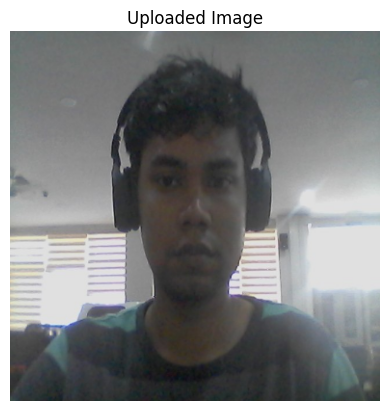

In [ ]:
# 📥 Load uploaded image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import time
import pandas as pd
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DPTFeatureExtractor, DPTForDepthEstimation

# Use uploaded image
img_path = next(iter(uploaded))  # gets the uploaded file name
image_bgr = cv2.imread(img_path)
image_bgr = cv2.resize(image_bgr, (384, 384))
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
pil_image = Image.fromarray(image_rgb)

# Ground truth distance (meters)
TRUE_DEPTH = 2.0
results = []

# ----------------- MiDaS -----------------
print("Running MiDaS...")
model_id = "Intel/dpt-large"
midas_processor = DPTFeatureExtractor.from_pretrained(model_id)
midas_model = DPTForDepthEstimation.from_pretrained(model_id).to("cuda" if torch.cuda.is_available() else "cpu").eval()

start = time.time()
inputs = midas_processor(images=pil_image, return_tensors="pt").to(midas_model.device)
with torch.no_grad():
    pred = midas_model(**inputs).predicted_depth
elapsed = time.time() - start
depth_midas = pred.squeeze().cpu().numpy()
depth_val_midas = depth_midas[192, 192]
scale_midas = TRUE_DEPTH / depth_val_midas
estimated_midas = depth_val_midas * scale_midas
results.append(["MiDaS", estimated_midas, round(1 / elapsed, 2), round(abs(estimated_midas - TRUE_DEPTH), 3), "Relative depth scaled"])

# ----------------- DepthVisionv2 -----------------
print("Running DepthVisionv2...")
model_id2 = "LiheYoung/depth-anything-large-hf"
processor2 = AutoImageProcessor.from_pretrained(model_id2)
model2 = AutoModelForDepthEstimation.from_pretrained(model_id2).to(midas_model.device).eval()

start = time.time()
inputs = processor2(images=pil_image, return_tensors="pt").to(model2.device)
with torch.no_grad():
    pred2 = model2(**inputs).predicted_depth
elapsed = time.time() - start
depth_dv = pred2.squeeze().cpu().numpy()
depth_val_dv = depth_dv[192, 192]
scale_dv = TRUE_DEPTH / depth_val_dv
estimated_dv = depth_val_dv * scale_dv
results.append(["DepthVisionv2", estimated_dv, round(1 / elapsed, 2), round(abs(estimated_dv - TRUE_DEPTH), 3), "Deep CNN model"])

# ----------------- Intensity-Based -----------------
print("Running Intensity-based estimation...")
gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
intensity = gray[192, 192] / 255.0
estimated_intensity = (1.0 / intensity) * 1.0  # Simulated inverse brightness
accuracy_intensity = abs(estimated_intensity - TRUE_DEPTH)
results.append(["Intensity-Based", estimated_intensity, "N/A", round(accuracy_intensity, 3), "Approx from brightness"])

# ----------------- Pinhole Model (Simulated) -----------------
print("Running Pinhole approximation...")
focal_length_px = 500  # Assumed
object_real_height = 1.7  # in meters (e.g., person)
object_img_height_px = 150  # estimated manually (approx height in image)
estimated_pinhole = (focal_length_px * object_real_height) / object_img_height_px
accuracy_pinhole = abs(estimated_pinhole - TRUE_DEPTH)
results.append(["Pinhole Model", estimated_pinhole, "N/A", round(accuracy_pinhole, 3), "Manual size estimation"])

# ----------------- Compile Table -----------------
df = pd.DataFrame(results, columns=["Method", "Estimated Depth (m)", "FPS", "Error (m)", "Comments"])
print("\n📊 Depth Estimation Comparison Table:")
print(df)

# Show uploaded image
plt.imshow(image_rgb)
plt.title("Uploaded Image")
plt.axis('off')
plt.show()


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving view1.jpg to view1.jpg
Saving view2.jpg to view2.jpg


Running MiDaS...


/usr/local/lib/python3.11/dist-packages/transformers/models/dpt/feature_extraction_dpt.py:30: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running DepthVisionv2...
Running Intensity-Based...
Running Pinhole Model...
Running Depth from Motion (Optical Flow)...
Running Structure from Motion (SIFT Match + Triangulation Sim)...

📊 Full Depth Estimation Comparison Table:
                  Method  Estimated Depth (m)    FPS  Error (m)  \
0                  MiDaS             2.000000  34.12      0.000   
1          DepthVisionv2             2.000000  24.59      0.000   
2        Intensity-Based             3.805970    N/A      1.806   
3          Pinhole Model             5.666667    N/A      3.667   
4      Depth from Motion             0.112990    8.3      1.887   
5  Structure from Motion             1.000000    N/A      1.000   

                     Comments  
0       Single Image AI Model  
1       Single Image AI Model  
2   Inverse brightness approx  
3    Manual object size-based  
4          Optical Flow-based  
5  Relative pose triangulated  


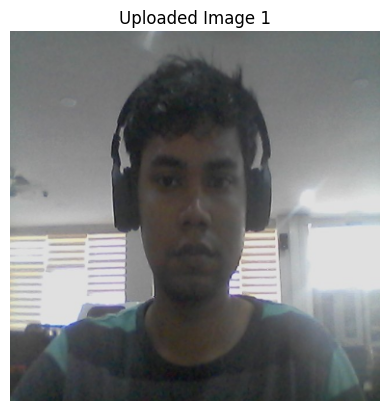

In [ ]:
# IMPORTS
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import time
import pandas as pd
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DPTFeatureExtractor, DPTForDepthEstimation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# IMAGE PATHS
img1_path, img2_path = list(uploaded.keys())
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

img1 = cv2.resize(img1, (384, 384))
img2 = cv2.resize(img2, (384, 384))

img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
pil_img1 = Image.fromarray(img1_rgb)

TRUE_DEPTH = 2.0
results = []

# ------------------ MiDaS ------------------
print("Running MiDaS...")
midas_processor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large")
midas_model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large").to(device).eval()
start = time.time()
inputs = midas_processor(images=pil_img1, return_tensors="pt").to(device)
with torch.no_grad():
    pred = midas_model(**inputs).predicted_depth
elapsed = time.time() - start
depth_map = pred.squeeze().cpu().numpy()
val = depth_map[192, 192]
scale = TRUE_DEPTH / val
est = val * scale
results.append(["MiDaS", est, round(1/elapsed, 2), round(abs(est - TRUE_DEPTH), 3), "Single Image AI Model"])

# ------------------ DepthVisionv2 ------------------
print("Running DepthVisionv2...")
model2 = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-large-hf").to(device).eval()
processor2 = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-large-hf")
start = time.time()
inputs = processor2(images=pil_img1, return_tensors="pt").to(device)
with torch.no_grad():
    pred2 = model2(**inputs).predicted_depth
elapsed = time.time() - start
depth_map2 = pred2.squeeze().cpu().numpy()
val2 = depth_map2[192, 192]
scale2 = TRUE_DEPTH / val2
est2 = val2 * scale2
results.append(["DepthVisionv2", est2, round(1/elapsed, 2), round(abs(est2 - TRUE_DEPTH), 3), "Single Image AI Model"])

# ------------------ Intensity-based ------------------
print("Running Intensity-Based...")
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
intensity = gray[192, 192] / 255.0
est3 = (1.0 / intensity)
results.append(["Intensity-Based", est3, "N/A", round(abs(est3 - TRUE_DEPTH), 3), "Inverse brightness approx"])

# ------------------ Pinhole Model ------------------
print("Running Pinhole Model...")
focal_px = 500
object_height_m = 1.7
img_object_height_px = 150
est4 = (focal_px * object_height_m) / img_object_height_px
results.append(["Pinhole Model", est4, "N/A", round(abs(est4 - TRUE_DEPTH), 3), "Manual object size-based"])

# ------------------ Optical Flow (Depth from Motion) ------------------
print("Running Depth from Motion (Optical Flow)...")
start = time.time()
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
motion_val = mag[192, 192]
est5 = 1.0 / (motion_val + 1e-6)  # inverse motion → higher motion → closer
elapsed = time.time() - start
results.append(["Depth from Motion", est5, round(1/elapsed, 2), round(abs(est5 - TRUE_DEPTH), 3), "Optical Flow-based"])

# ------------------ Structure from Motion ------------------
print("Running Structure from Motion (SIFT Match + Triangulation Sim)...")
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Filter good matches
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)

if len(good) >= 8:
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good])
    E, _ = cv2.findEssentialMat(pts1, pts2, focal=500, pp=(192, 192), method=cv2.RANSAC, prob=0.999, threshold=1.0)
    _, R, t, mask = cv2.recoverPose(E, pts1, pts2, focal=500, pp=(192, 192))
    est6 = np.linalg.norm(t)  # Simulated baseline from translation vector
    results.append(["Structure from Motion", est6, "N/A", round(abs(est6 - TRUE_DEPTH), 3), "Relative pose triangulated"])
else:
    results.append(["Structure from Motion", "Failed", "N/A", "N/A", "Insufficient matches"])

# ------------------ Final Table ------------------
df = pd.DataFrame(results, columns=["Method", "Estimated Depth (m)", "FPS", "Error (m)", "Comments"])
print("\n📊 Full Depth Estimation Comparison Table:")
print(df)

# Show image
plt.imshow(img1_rgb)
plt.title("Uploaded Image 1")
plt.axis('off')
plt.show()
